# Which plan is best?

You are an analyst for the telecom operator Megaline. The company offers two prepaid plans, Surf and Ultimate. Marketing wants to know which plan brings in more revenue to allocate ad spend. You will analyze 2018 usage for 500 customers (who they are, where they live, which plan they use, and how many calls/texts they made). The goal is to understand customer behavior and determine which prepaid plan generates more income.


**Data analysis plan**

1. Load all datasets needed for the project (customers, plans, calls, etc.). Standardize column names, check for missing values, duplicates, and incorrect dtypes. Convert variables to appropriate types (dates to datetime, categories to category).
2. Prepare and combine the data into a single master DataFrame. Create derived variables (minutes per user per month, revenue per plan) and ensure dtypes are appropriate for later analysis.
3. Perform descriptive analysis grouped by plan and month: compute means, medians, variances, user counts, and plot histograms, bar charts, and boxplots to spot differences across plans and over time.
4. Run hypothesis tests: check normality (Shapiro–Wilk) and choose t-tests when normal, otherwise Mann–Whitney U. Define clear null (no difference) and alternative (difference exists) hypotheses.
5. Summarize test results with statistics and p-values, interpret significance, and link findings to the business question (which plan to promote) and whether usage varies over time.


## 1. Initialization


In [69]:
# Load all libraries
import pandas as pd 
import numpy as np 
import calendar
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns 
import warnings
from matplotlib import style 
plt.style.use ("ggplot")
warnings.filterwarnings ("ignore")


## 2. Load data


In [70]:
calls = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\megaline_calls.csv")
internet = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\megaline_internet.csv")
messages = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\megaline_messages.csv")
plans = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\megaline_plans.csv")
users = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\megaline_users.csv")


## 3. Prepare the data


## 4. Plans


In [71]:
# Print general/summary info for the plan DataFrame
plans.info ()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [72]:
# Show a sample of the plan data
plans.sample()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Reviewing the plans DataFrame showed no missing values, no duplicates, and coherent dtypes. No cleaning or enrichment was required.


## 5. Enrich the data


Added a column to convert monthly megabytes to gigabytes by dividing by 1,000 (1 GB = 1,000 MB).


In [73]:
plans ["gb_per_month_included"] = plans ["mb_per_month_included"]/1000


## 6. Users


In [74]:
# Print general/summary info for the users DataFrame
print (users.info()) 
print ()
print ("Duplicate values:" ,users.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Duplicate values: 0


In [75]:
# Show a sample of the users data
users.sample ()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
330,1330,Tobi,Kinney,48,"Las Vegas-Henderson-Paradise, NV MSA",11/6/2018,ultimate,NaN


Like the plans table, the users DataFrame has no missing values that need filling. `churn_date` has nulls as expected for active customers. `duplicated()` confirms no duplicates. Date columns (`reg_date`, `churn_date`) should be converted from string to datetime64[ns] to ease future analysis; otherwise no changes needed.


### Fix the data


In [76]:
users ["reg_date"] = pd.to_datetime (users ["reg_date"], format = "%m/%d/%Y")
users ["churn_date"] = pd.to_datetime (users ["churn_date"], format= "%m/%d/%Y")


### Calls


In [77]:
# Print general/summary info for the calls DataFrame
print (calls.info()) 
print ()
print ("Duplicate values:", calls.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

Duplicate values: 0


In [78]:
# Show a sample of the calls data
calls.sample()


,id,user_id,call_date,duration
51809,1187_2,1187,12/31/2018,1.9


### Fix the data


The calls DataFrame has no missing values or duplicates. The `call_date` column is stored as string and should be converted to datetime for time-based analysis; no other changes are required.


In [79]:
calls ["call_date"] = pd.to_datetime (calls ["call_date"], format= "%m/%d/%Y")


### Enrich the data


A `month` column was added from `call_date` using `dt.month_name()`. Minutes per call were rounded up with `np.ceil` to match Megaline's billing rules, then cast to integer.


In [80]:
calls ["month"] = calls["call_date"].dt.month_name(locale="en_US")
calls ["duration"] = calls ["duration"].apply (np.ceil).astype ("int")


## 7. Messages


In [81]:
# Print general/summary info for the messages DataFrame
print (messages.info())
print ()
print ("Duplicate values:", messages.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Duplicate values: 0


In [82]:
# Show a sample of the messages data
messages.sample ()


,id,user_id,message_date
30333,1191_38,1191,5/23/2018


### Fix the data


No missing values or duplicates were found. `message_date` is stored as string and should be converted to datetime64[ns] to work with dates properly.


In [83]:
messages ["message_date"] = pd.to_datetime (messages["message_date"], format = "%m/%d/%Y")


### Enrich the data


A `month` column was added to `messages` from `message_date` via `dt.month_name()`.


In [84]:
messages ["month"] = messages ["message_date"].dt.month_name(locale="en_US")


## 8. Internet


In [85]:
# Print general/summary info for the internet DataFrame
print (internet.info())
print ()
print ("Duplicate values:", internet.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

Duplicate values: 0


In [86]:
# Show a sample of the internet traffic data
internet.sample()


,id,user_id,session_date,mb_used
95577,1445_225,1445,6/7/2018,685.3


### Fix the data


The internet DataFrame also has no missing or duplicated records. `session_date` is stored as string and should be converted to datetime64[ns]; no other changes are needed.


In [87]:
internet ["session_date"] = pd.to_datetime (internet ["session_date"], format = "%m/%d/%Y")


### Enrich the data


Added a `month` column from `session_date` using `dt.month_name()` and converted traffic from MB to GB.


In [88]:
# Convert to GB 
internet ["gb_used"] = internet["mb_used"] / 1000
internet ["month"] = internet ["session_date"].dt.month_name(locale="en_US")


## 9. Study the tariff conditions


In [89]:
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.36
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.72


## 10. Aggregate data by user


In [90]:
# Calculate the number of calls per user per month. Store the result.
# Calculate total minutes per user per month. Store the result.

total_calls = calls.groupby (["user_id", "month"]).agg (calls_count = ("id", "count"),
                                             total_duration = ("duration", "sum"))


In [91]:
# Calculate the number of messages per user per month. Store the result.

total_messages = messages.groupby (["user_id", "month"]).agg (
    messages_count = ("id", "count"))


In [92]:
# Calculate the internet traffic volume per user per month. Store the result.

internet_traffic = internet.groupby (["user_id", "month"]).agg (
    total_gb = ("gb_used", "sum"))


In [93]:
# Merge call, minute, message, and internet data on user_id and month

combined_frames = total_calls.merge (
    total_messages, left_index= True, right_index= True, how = "outer").merge(
    internet_traffic, left_index = True, right_index = True, how = "outer").reset_index().merge (
    users[["user_id", "plan", "city"]], on = "user_id", how = "outer").merge (
    plans,left_on = "plan", right_on="plan_name",how= "outer")

combined_frames = combined_frames.fillna({
    "total_duration": 0,
    "messages_count": 0,
    "total_gb": 0
})


In [94]:
# Calculate monthly revenue for each user

combined_frames["cost_extra_mins"] = (
    (combined_frames ["total_duration"] - combined_frames["minutes_included"]).clip(
        lower = 0)) * combined_frames ["usd_per_minute"]

combined_frames["cost_extra_sms"] = (
    (combined_frames["messages_count"] - combined_frames["messages_included"]).clip(
        lower = 0)) * combined_frames ["usd_per_message"]

combined_frames["cost_extra_gb"] = ((
    (combined_frames["total_gb"] - combined_frames["gb_per_month_included"]).clip(
        lower = 0)).apply (np.ceil))*combined_frames["usd_per_gb"]

combined_frames["total_cost_per_month"] = combined_frames["usd_monthly_pay"]+combined_frames["cost_extra_mins"]+combined_frames["cost_extra_sms"]+combined_frames["cost_extra_gb"]


In [95]:
ty = combined_frames.groupby (["plan", "user_id"]).agg(count = ("month", "count")).reset_index()
ty = ty.groupby ("plan").count() 
ty


,user_id,count
plan,,
surf,339,339
ultimate,161,161


## 11. Study user behavior


### Calls


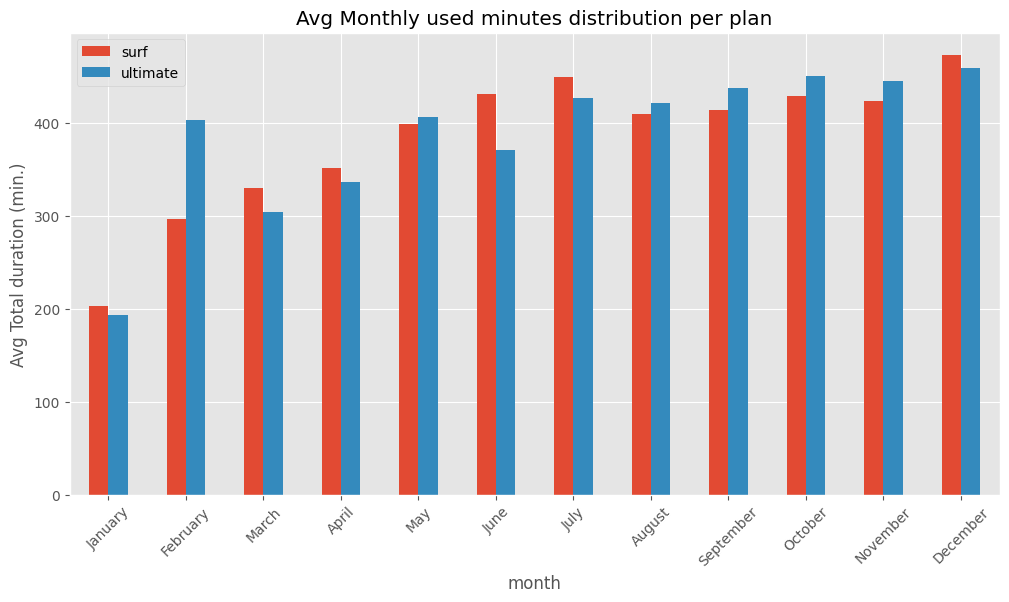

In [96]:
# Compare average call duration per plan and per month; plot a bar chart.
call_duration = combined_frames.pivot_table(
    index = "month", 
    columns = "plan", 
    values = "total_duration", 
    aggfunc = "mean").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month) 


call_duration.plot (
    kind = "bar",
    figsize = (12,6),
    title = "Avg Monthly used minutes distribution per plan",
    xlabel = "month", 
    ylabel = "Avg Total duration (min.)",
    rot = 45
)

plt.legend ()
plt.show ()


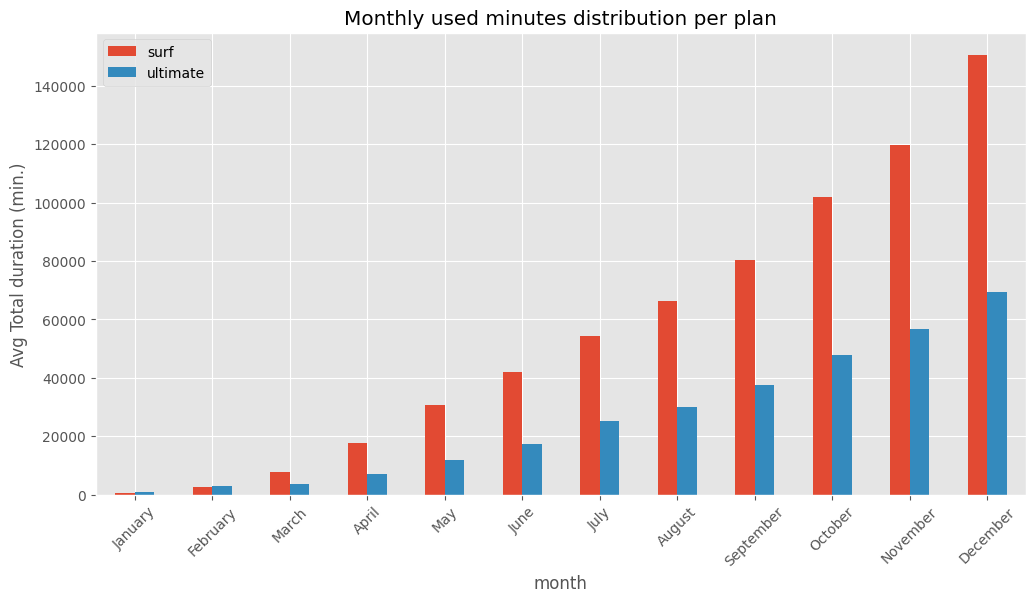

In [97]:
call_duration = combined_frames.pivot_table(
    index = "month", 
    columns = "plan", 
    values = "total_duration", 
    aggfunc = "sum").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month) 


call_duration.plot (
    kind = "bar",
    figsize = (12,6),
    title = "Monthly used minutes distribution per plan",
    xlabel = "month", 
    ylabel = "Avg Total duration (min.)",
    rot = 45
)

plt.legend ()
plt.show ()


Two chart approaches were used: (1) average minutes per month by plan and (2) total minutes per month by plan. Averages are similar across plans with minor monthly differences; total minutes are much higher for Surf because it has more subscribers. Per-user and total metrics both matter to avoid biased conclusions.


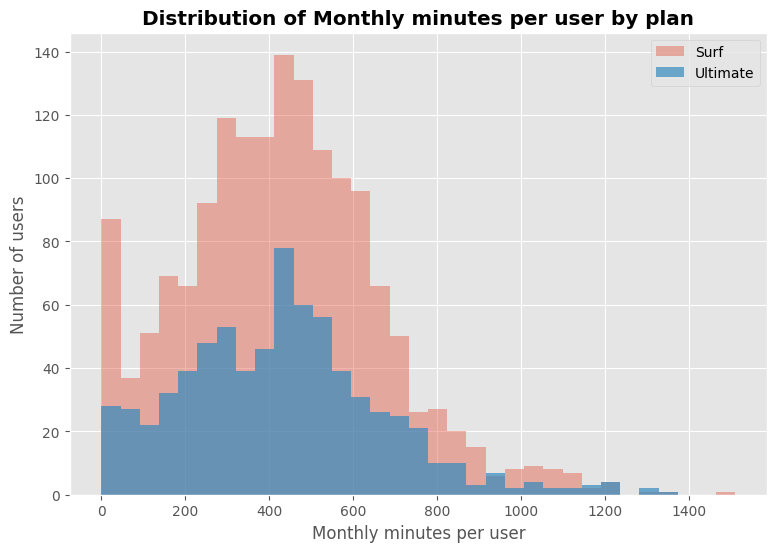

In [98]:
# Compare monthly minutes used by users of each plan; plot a histogram.
monthly_minutes = combined_frames.groupby (
    ["plan", "month", "user_id"], as_index=False)["total_duration"].sum()

bins = np.histogram_bin_edges(monthly_minutes["total_duration"], bins = "auto")

data_surf = monthly_minutes[monthly_minutes["plan"] == "surf"]
surf = data_surf ["total_duration"]
data_ultimate = monthly_minutes[monthly_minutes["plan"] == "ultimate"]
ultimate = data_ultimate["total_duration"]

fig, ax = plt.subplots (figsize = (9,6))
plt.hist (x = surf, bins = bins, alpha = 0.4, label = "Surf")
plt.hist (x = ultimate, bins = bins, alpha = 0.7, label = "Ultimate")
plt.title ("Distribution of Monthly minutes per user by plan", fontdict= {"weight":"bold"})
plt.xlabel ("Monthly minutes per user")
plt.ylabel ("Number of users")
plt.legend ()
plt.show ()


The monthly histogram shows most users fall near the same minute range in both plans, with Surf showing more overall volume because of its larger user base.


In [99]:
# Calculate the mean and variance of monthly call duration.

call_stats = combined_frames.groupby (["plan", "month"])["total_duration"].agg (
    mean = ("mean"), variance = ("var"), std = (np.std))

call_stats = (
    call_stats.reset_index()
    .sort_values (
        by = ["plan", "month"],
        key = lambda s: pd.to_datetime (s, format = "%B").dt.month if s.name == "month" else s
    )
    .set_index (["plan", "month"])
)
call_stats


mean      variance         std
plan     month                                          
surf     January    203.000000  15842.000000  125.865007
         February   297.000000  52226.500000  228.531179
         March      330.000000  35809.363636  189.233622
         April      351.540000  50866.743265  225.536567
         May        399.584416  59754.219754  244.446763
         June       431.298969  45592.628436  213.524304
         July       449.983471  61005.099725  246.992105
         August     410.111111  54344.645963  233.119381
         September  414.226804  46595.958656  215.860971
         October    429.729958  52278.664056  228.645280
         November   423.325088  51607.021602  227.171789
         December   473.836478  63629.518918  252.248923
ultimate January    193.500000  16572.333333  128.733575
         February   403.142857  76889.476190  277.289517
         March      304.250000  61984.931818  248.967732
         April      336.857143  34888.928571  186.785783
         May        406.241379  43841.046798  209.382537
         June       370.957447  42503.563367  206.163924
         July       427.067797  72563.374635  269.375898
         August     421.436620  53645.506640  231.614997
         September  437.511628  57070.464569  238.894254
         October    450.735849  54261.910512  232.941861
         November   445.196850  60593.222847  246.156907
         December   459.099338  62503.783400  250.007567

- **Mean:** Average monthly minutes per user are close between plans, with Surf slightly lower.
- **Variance:** Dispersion grows over the year for both plans, reflecting varied usage patterns.


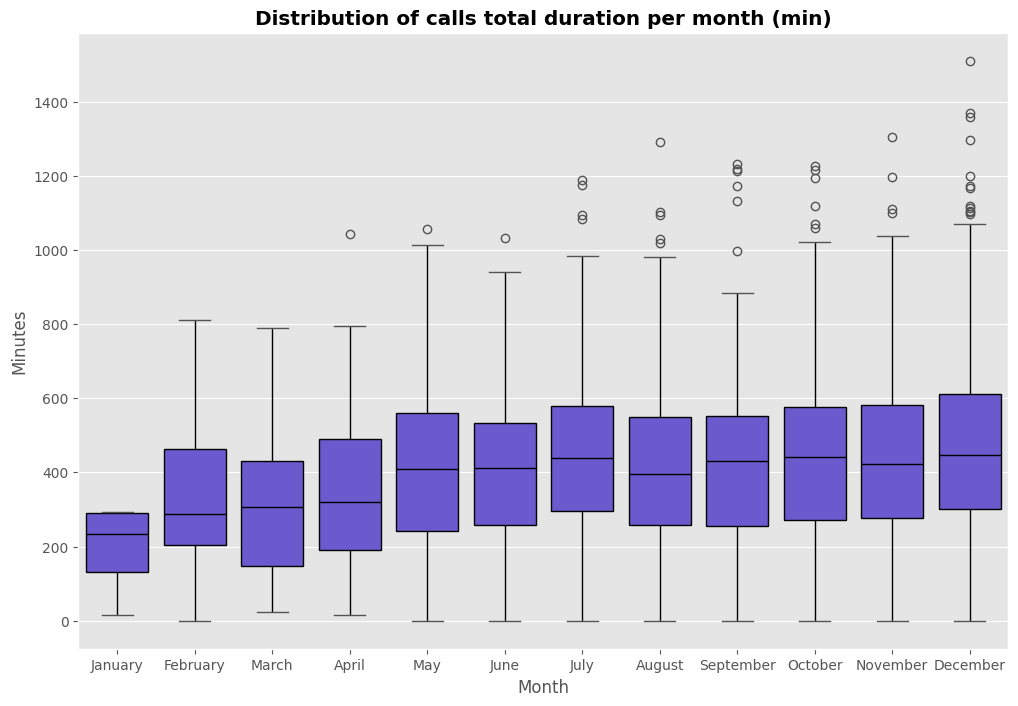

In [100]:
# Plot a boxplot to show the distribution of monthly call duration
order = list(calendar.month_name)[1:]

plt.figure (figsize= (12,8))
sns.boxplot (
    data = combined_frames, 
    x = "month", 
    y = "total_duration",
    order = order, 
    boxprops = dict (facecolor = "slateblue", edgecolor = "black"),
    whiskerprops = dict (color = "black"),
    medianprops = dict (color = "black")
)

plt.title ("Distribution of calls total duration per month (min)", fontdict = {"weight": "bold"})
plt.xlabel ("Month")
plt.ylabel ("Minutes")
plt.show ()


The boxplot shows call duration per month increasing through the year; variability also grows, indicating a mix of light and heavy callers.


Call behavior differs mainly due to subscriber count: per-user usage is similar, but Surf dominates total minutes because more people use it.


### Messages


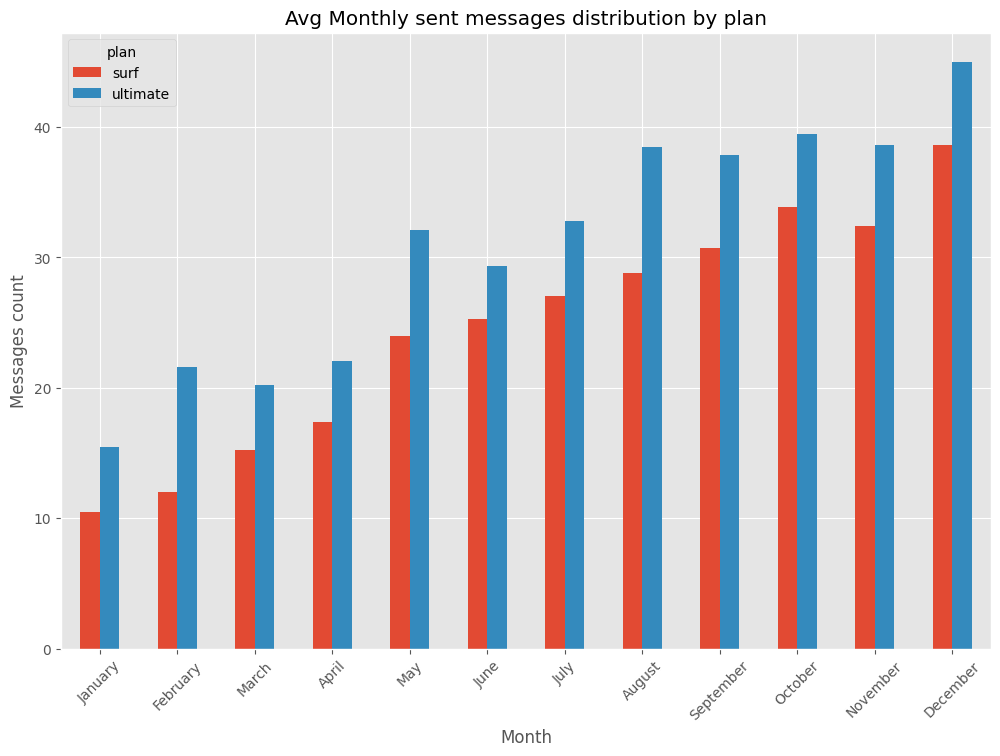

In [101]:
messages_per_user = combined_frames.pivot_table (
    index = "month", 
    columns = "plan", 
    values = "messages_count", 
    aggfunc= "mean").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month)

messages_per_user.plot (
    kind = "bar", 
    figsize = (12,8), 
    title = ("Avg Monthly sent messages distribution by plan"),
    xlabel = "Month",
    ylabel = "Messages count",
    rot = 45
)
plt.show()


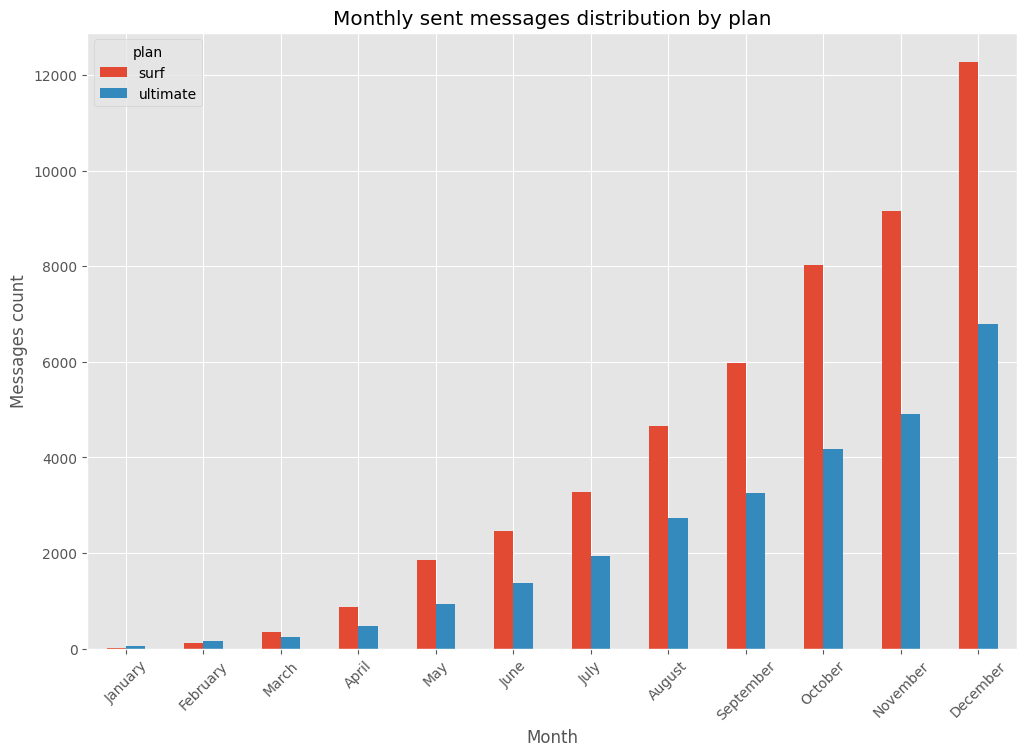

In [102]:
# Compare how many messages per month users of each plan send

messages_per_user = combined_frames.pivot_table (
    index = "month", 
    columns = "plan", 
    values = "messages_count", 
    aggfunc= "sum").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month)

messages_per_user.plot (
    kind = "bar", 
    figsize = (12,8), 
    title = ("Monthly sent messages distribution by plan"),
    xlabel = "Month",
    ylabel = "Messages count", 
    rot = 45
)
plt.show()


As with calls, two visuals were used: (1) average messages per month by plan and (2) total messages per month by plan.


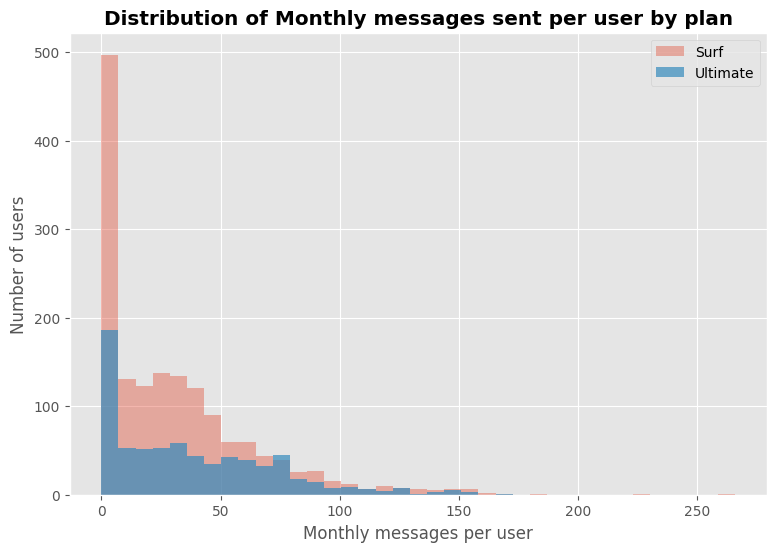

In [103]:
# Compare monthly minutes used by users of each plan; plot a histogram.
monthly_messages = combined_frames.groupby (
    ["plan", "month", "user_id"], as_index=False)["messages_count"].sum()

bins = np.histogram_bin_edges(monthly_messages["messages_count"], bins = "auto")

data_surf_sms = monthly_messages[monthly_messages["plan"] == "surf"]
surf_sms = data_surf_sms ["messages_count"]
data_ultimate_sms = monthly_messages[monthly_messages["plan"] == "ultimate"]
ultimate_sms = data_ultimate_sms["messages_count"]

fig, ax = plt.subplots (figsize = (9,6))
plt.hist (x = surf_sms, bins = bins, alpha = 0.4, label = "Surf")
plt.hist (x = ultimate_sms, bins = bins, alpha = 0.7, label = "Ultimate")
plt.title ("Distribution of Monthly messages sent per user by plan", fontdict= {"weight":"bold"})
plt.xlabel ("Monthly messages per user")
plt.ylabel ("Number of users")
plt.legend ()
plt.show ()


The histogram confirms Surf has more users, so its total messages are higher. Ultimate users send more messages per person, highlighting heavier per-user usage.


In [104]:
# Calculate the mean and variance of monthly call duration.

sms_stats = combined_frames.groupby (["plan", "month"])["messages_count"].agg (
    mean = ("mean"), variance = ("var"), std = (np.std))
sms_stats = (
    sms_stats.reset_index()
    .sort_values (
        by = ["plan", "month"],
        key = lambda s: pd.to_datetime (s, format = "%B").dt.month if s.name == "month" else s
    )
    .set_index (["plan", "month"])
)

sms_stats


mean     variance        std
plan     month                                       
surf     January    10.500000   220.500000  14.849242
         February   12.000000   386.000000  19.646883
         March      15.260870   346.565217  18.616262
         April      17.400000   501.591837  22.396246
         May        24.012987   847.197198  29.106652
         June       25.298969   914.920103  30.247646
         July       27.033058   923.915565  30.395979
         August     28.777778  1029.515528  32.086064
         September  30.762887  1003.829496  31.683268
         October    33.839662  1275.465708  35.713663
         November   32.385159  1065.344034  32.639608
         December   38.600629  1458.158612  38.185843
ultimate January    15.500000   313.666667  17.710637
         February   21.571429   478.285714  21.869744
         March      20.250000   654.386364  25.580977
         April      22.047619   544.147619  23.326972
         May        32.103448  1297.310345  36.018195
         June       29.340426   857.620722  29.285162
         July       32.830508   960.488019  30.991741
         August     38.478873  1196.367404  34.588544
         September  37.895349  1050.918331  32.417871
         October    39.443396  1221.106289  34.944331
         November   38.606299  1232.669166  35.109389
         December   45.006623  1549.419956  39.362672

- **Mean:** Surf users send fewer texts per month than Ultimate users.
- **Variance & Std Dev:** Both plans show growing dispersion over the year, with Ultimate often showing higher variability due to heavy texters.


Text(0, 0.5, 'Messages')

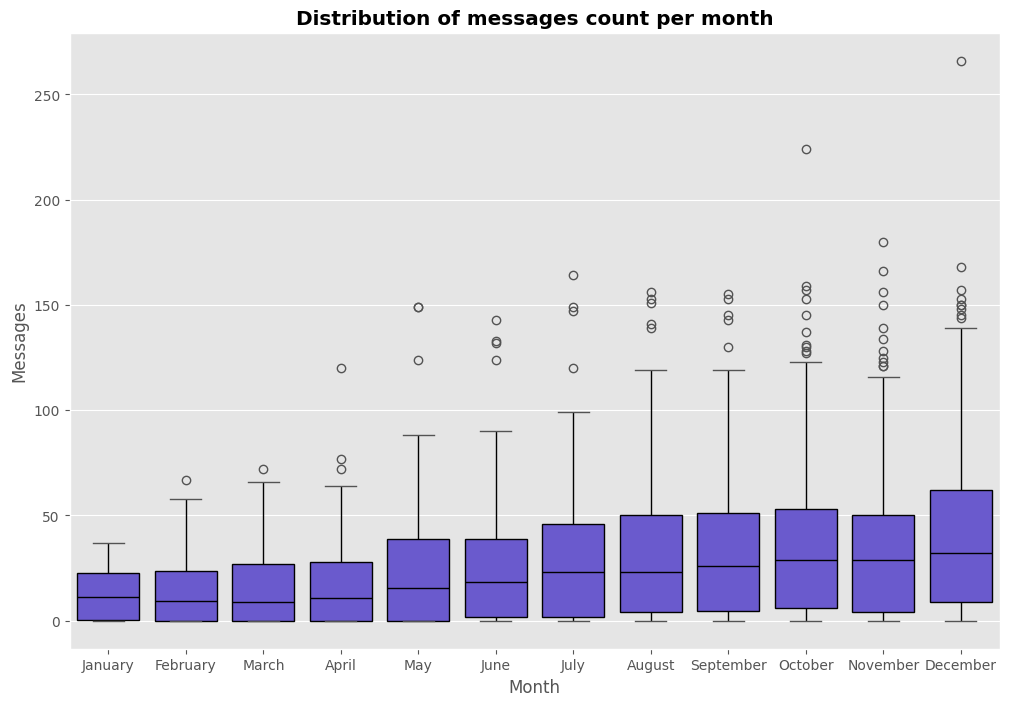

In [105]:
order = list(calendar.month_name)[1:]
plt.figure (figsize= (12,8))
sns.boxplot (
    data = combined_frames, 
    x = "month", 
    y = "messages_count",
    order = order, 
    boxprops = dict (facecolor = "slateblue", edgecolor = "black"),
    whiskerprops = dict (color = "black"),
    medianprops = dict (color = "black")
)
plt.title ("Distribution of messages count per month", fontdict = {"weight": "bold"})
plt.xlabel ("Month")
plt.ylabel ("Messages")


The boxplot shows medians and spread of messages increasing through the year, with more outliers later, suggesting a rising share of heavy texters.


Overall messaging takeaway: texting grows toward year end (seasonality). Ultimate users send more per person, while Surf dominates total counts because it has more users. Distributions are skewed with a small group of heavy texters in both plans.


### Internet


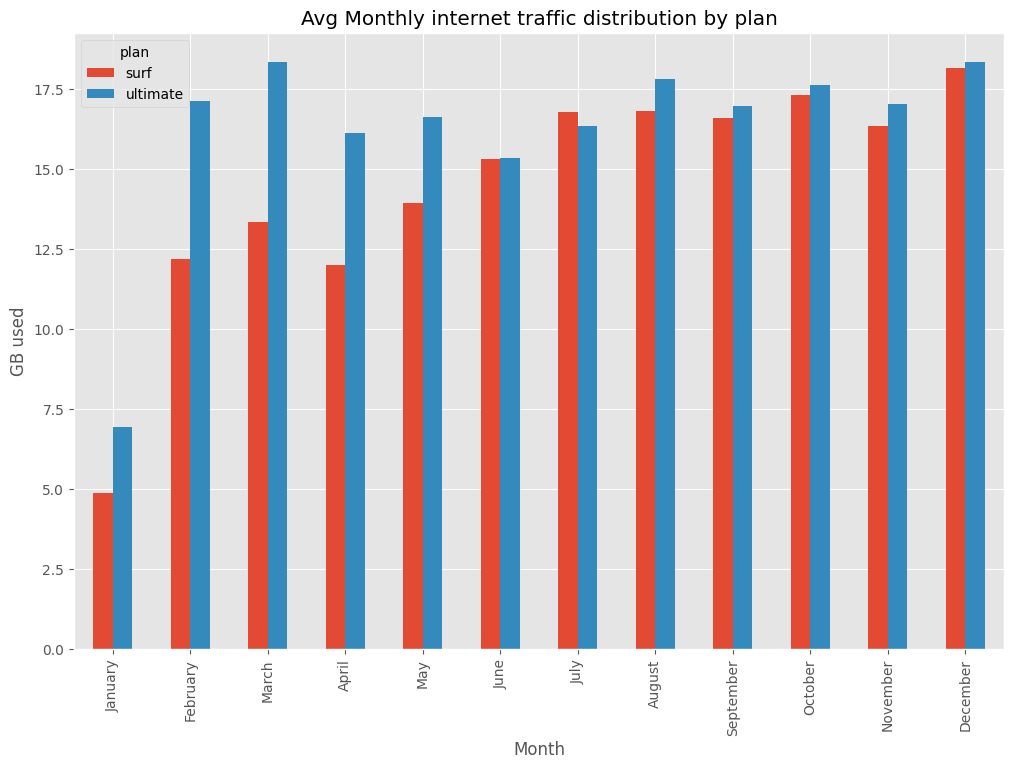

In [106]:
# Compare the amount of internet traffic consumed by users by plan
gb_per_user = combined_frames.pivot_table (
    index = "month", 
    columns = "plan", 
    values = "total_gb", 
    aggfunc= "mean").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month)

gb_per_user.plot (
    kind = "bar", 
    figsize = (12,8), 
    title = ("Avg Monthly internet traffic distribution by plan"),
    xlabel = "Month",
    ylabel = "GB used"
)
plt.show()


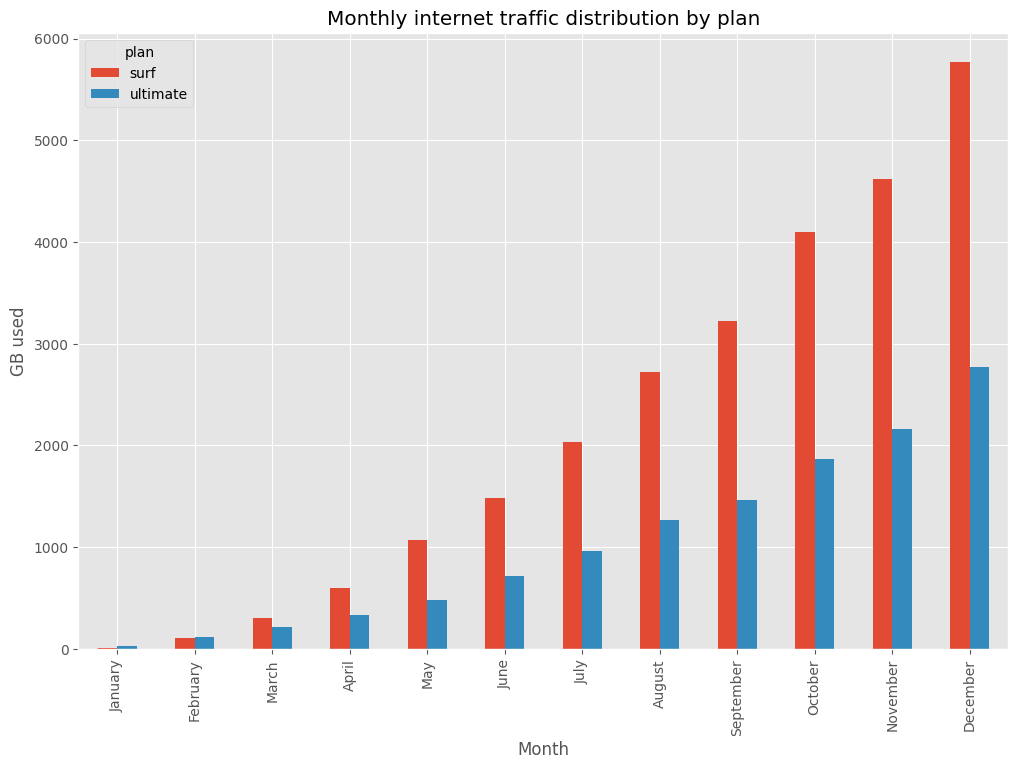

In [107]:
# Compare the amount of internet traffic consumed by users by plan
gb_per_user = combined_frames.pivot_table (
    index = "month", 
    columns = "plan", 
    values = "total_gb", 
    aggfunc= "sum").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month)

gb_per_user.plot (
    kind = "bar", 
    figsize = (12,8), 
    title = ("Monthly internet traffic distribution by plan"),
    xlabel = "Month",
    ylabel = "GB used"
)
plt.show()


Two visuals were used: (1) average monthly internet traffic (GB) by plan and (2) total monthly traffic by plan.


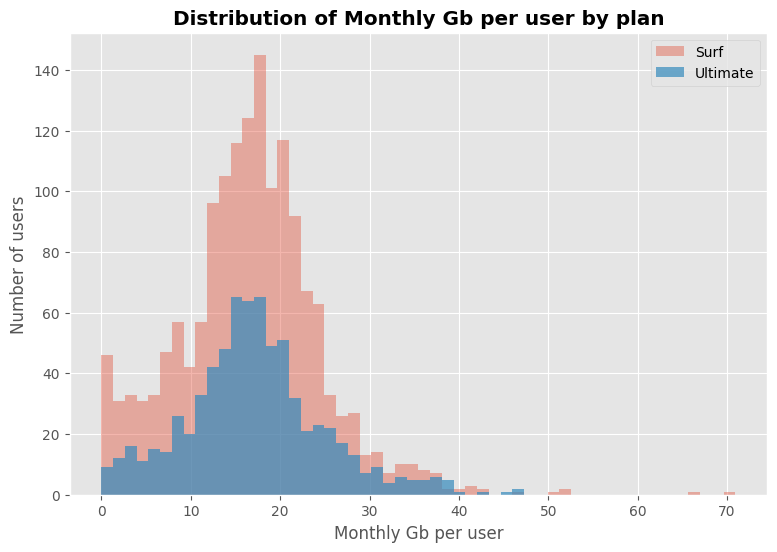

In [108]:
monthly_gb = combined_frames.groupby (
    ["plan", "month", "user_id"], as_index=False)["total_gb"].sum()

bins = np.histogram_bin_edges(monthly_gb["total_gb"], bins = "auto")

data_surf_gb = monthly_gb[monthly_gb["plan"] == "surf"]
surf_gb = data_surf_gb ["total_gb"]
data_ultimate_gb = monthly_gb[monthly_gb["plan"] == "ultimate"]
ultimate_gb = data_ultimate_gb["total_gb"]

fig, ax = plt.subplots (figsize = (9,6))
plt.hist (x = surf_gb, bins = bins, alpha = 0.4, label = "Surf")
plt.hist (x = ultimate_gb, bins = bins, alpha = 0.7, label = "Ultimate")
plt.title ("Distribution of Monthly Gb per user by plan", fontdict= {"weight":"bold"})
plt.xlabel ("Monthly Gb per user")
plt.ylabel ("Number of users")
plt.legend ()
plt.show ()


The histogram confirms Surf has the most users and thus the highest total mobile data volume. Ultimate users consume more GB per person, showing more intensive use.


In [109]:
gb_stats = combined_frames.groupby (["plan", "month"])["total_gb"].agg (
    mean = ("mean"), variance = ("var"), std = (np.std))
gb_stats = (
    gb_stats.reset_index()
    .sort_values (
        by = ["plan", "month"], 
        key = lambda s: pd.to_datetime (s, format = "%B").dt.month if s.name == "month" else s
    )
    .set_index (["plan", "month"])
)
gb_stats


mean    variance        std
plan     month                                      
surf     January     4.874860   18.239954   4.270826
         February   12.178843   43.672959   6.608552
         March      13.345440   68.245558   8.261087
         April      11.984203   59.044941   7.684071
         May        13.936355   61.476534   7.840697
         June       15.301529   49.133389   7.009521
         July       16.783601   64.686548   8.042795
         August     16.795331   74.636488   8.639241
         September  16.591431   51.316650   7.163564
         October    17.311335   62.527941   7.907461
         November   16.339254   57.175469   7.561446
         December   18.132469   72.147408   8.493963
ultimate January     6.918093   16.394712   4.049038
         February   17.128809   37.649096   6.135886
         March      18.321518  140.339165  11.846483
         April      16.121655   88.428607   9.403649
         May        16.624482   56.790116   7.535922
         June       15.337921   72.014532   8.486138
         July       16.344744   68.419211   8.271591
         August     17.814720   60.447084   7.774772
         September  16.969870   49.339038   7.024175
         October    17.612553   56.995277   7.549522
         November   17.033685   57.589478   7.588773
         December   18.323192   61.881301   7.866467

- **Mean:** Surf starts with low average GB and rises steadily; Ultimate stays higher throughout, peaking in months like March and December.
- **Variance & Std Dev:** Dispersion increases over time for both plans, indicating a mix of light and heavy data users, with Ultimate often showing sharper swings.


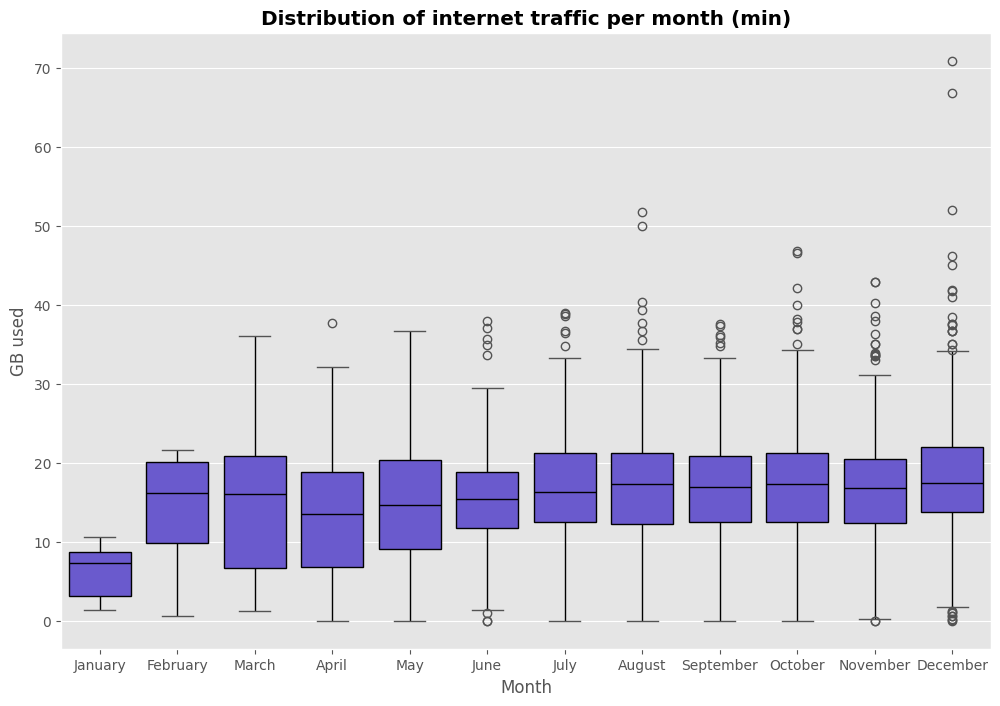

In [110]:
order = list(calendar.month_name)[1:]
plt.figure (figsize= (12,8))
sns.boxplot (
    data = combined_frames, 
    x = "month", 
    y = "total_gb",
    order = order, 
    boxprops = dict (facecolor = "slateblue", edgecolor = "black"),
    whiskerprops = dict (color = "black"),
    medianprops = dict (color = "black")
)

plt.title ("Distribution of internet traffic per month (min)", fontdict = {"weight": "bold"})
plt.xlabel ("Month")
plt.ylabel ("GB used")
plt.show ()


Monthly distributions show most users consume about 10–20 GB, with more outliers from mid-year onward; December has the most outliers, likely due to seasonal effects (holidays, vacations, higher digital activity).


Internet usage grows steadily across the year with clear seasonality. Ultimate users consume more per person; Surf leads total GB because of more users. Usage is heterogeneous: many moderate users and a minority of intensive users drive variability, especially late in the year.


## 12. Revenue


Describe plan revenues statistically just as with usage behavior.


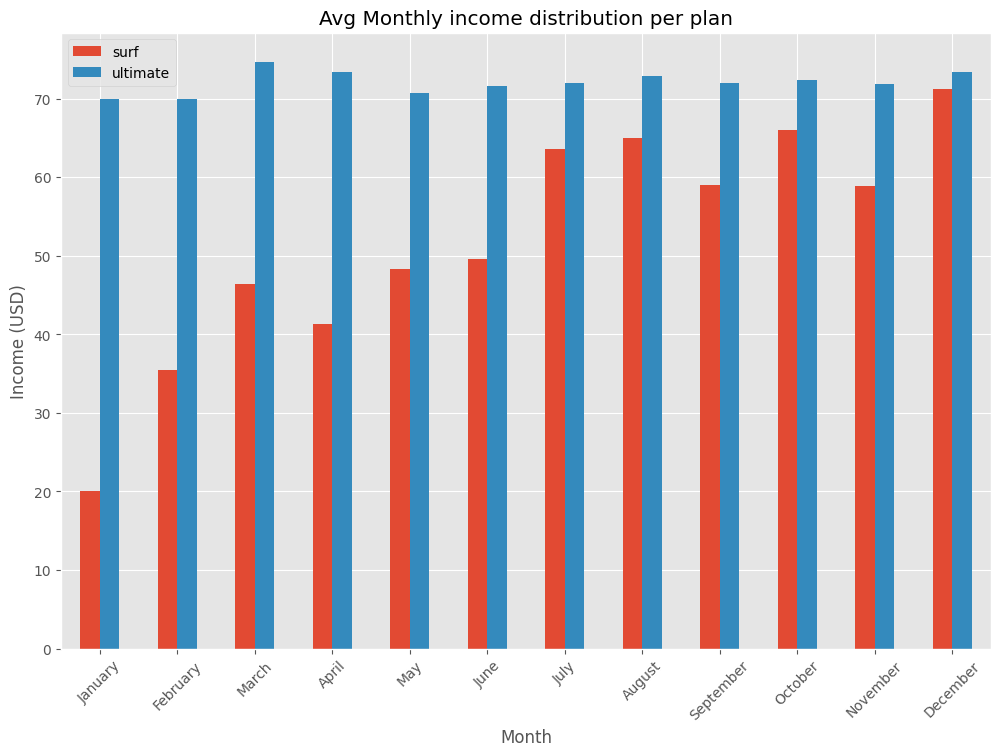

In [111]:
income = combined_frames.pivot_table(
    index = "month", 
    columns = "plan", 
    values = "total_cost_per_month", 
    aggfunc = "mean").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month) 


income.plot (
    kind = "bar",
    figsize = (12,8),
    title = "Avg Monthly income distribution per plan",
    xlabel = "Month", 
    ylabel = "Income (USD)",
    rot = 45
)

plt.legend ()
plt.show ()


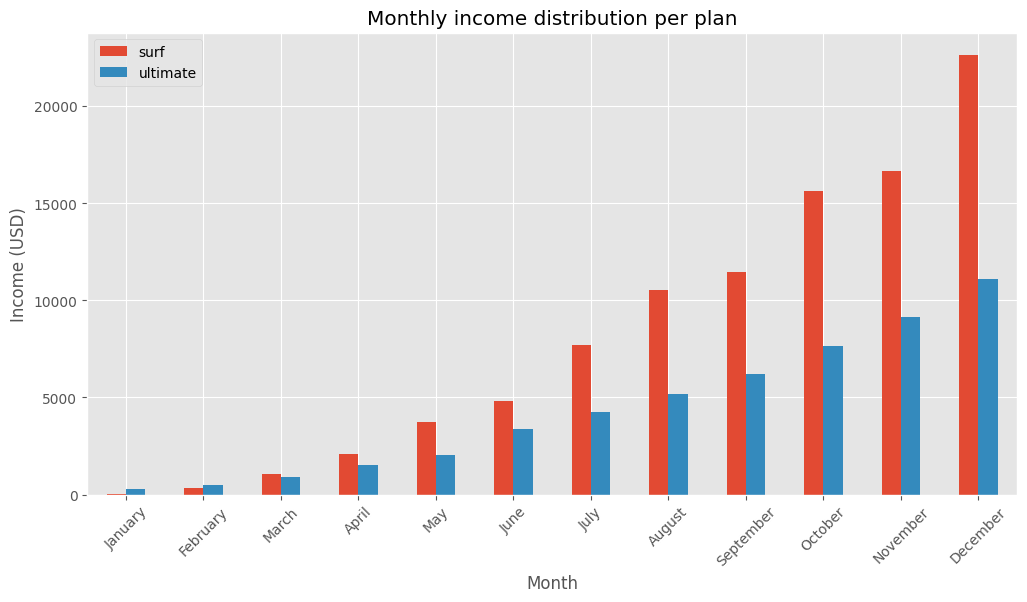

In [112]:
income = combined_frames.pivot_table(
    index = "month", 
    columns = "plan", 
    values = "total_cost_per_month", 
    aggfunc = "sum").sort_index (key = lambda s: pd.to_datetime(s, format = "%B").month) 


income.plot (
    kind = "bar",
    figsize = (12,6),
    title = "Monthly income distribution per plan",
    xlabel = "Month", 
    ylabel = "Income (USD)",
    rot = 45
)

plt.legend ()
plt.show ()


Two visuals were used: (1) average monthly revenue by plan and (2) total monthly revenue by plan.


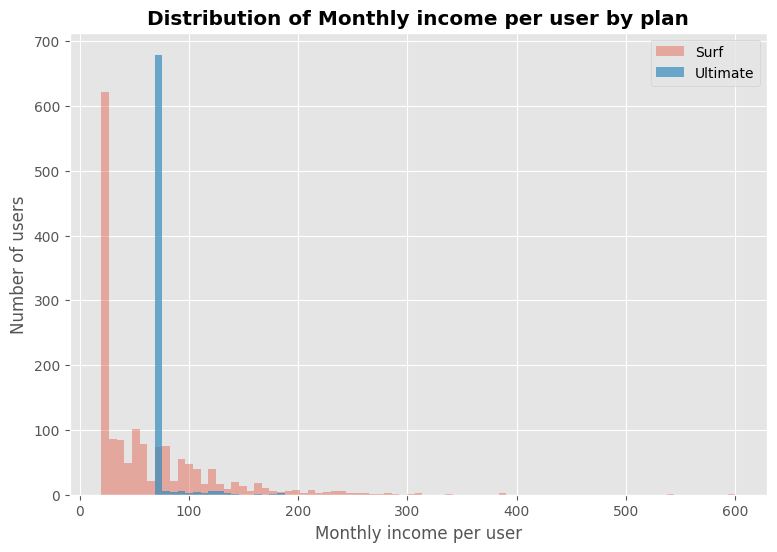

In [113]:
monthly_income = combined_frames.groupby (
    ["plan", "month", "user_id"], as_index=False)["total_cost_per_month"].sum()

bins = np.histogram_bin_edges(monthly_income["total_cost_per_month"], bins = "auto")

data_surf_income = monthly_income[monthly_income["plan"] == "surf"]
surf_income = data_surf_income ["total_cost_per_month"]
data_ultimate_income = monthly_income[monthly_income["plan"] == "ultimate"]
ultimate_income = data_ultimate_income["total_cost_per_month"]

fig, ax = plt.subplots (figsize = (9,6))
plt.hist (x = surf_income, bins = bins, alpha = 0.4, label = "Surf")
plt.hist (x = ultimate_income, bins = bins, alpha = 0.7, label = "Ultimate")
plt.title ("Distribution of Monthly income per user by plan", fontdict= {"weight":"bold"})
plt.xlabel ("Monthly income per user")
plt.ylabel ("Number of users")
plt.legend ()
plt.show ()


The histogram shows most Ultimate users cluster around the flat-fee amount, while Surf's larger base yields higher total revenue even when per-user amounts are lower.


In [114]:
income_stats = combined_frames.groupby (["plan", "month"])["total_cost_per_month"].agg (
    mean = ("mean"), variance = ("var"), std = (np.std))
income_stats = (
    income_stats.reset_index()
    .sort_values (
        by = ["plan", "month"], 
        key = lambda s: pd.to_datetime (s, format = "%B").dt.month if s.name == "month" else s
    )
    .set_index (["plan", "month"])
)
income_stats


mean     variance        std
plan     month                                       
surf     January    20.000000     0.000000   0.000000
         February   35.507778   528.395544  22.986856
         March      46.376087  1583.697425  39.795696
         April      41.310600  1310.027055  36.194296
         May        48.277532  2083.873137  45.649459
         June       49.585567  2061.244717  45.400933
         July       63.583140  3111.222652  55.778335
         August     64.980556  3799.645250  61.641263
         September  58.993144  2333.556640  48.306901
         October    66.011941  3292.642430  57.381551
         November   58.816996  2619.691121  51.182918
         December   71.248868  4777.107081  69.116619
ultimate January    70.000000     0.000000   0.000000
         February   70.000000     0.000000   0.000000
         March      74.666667   145.515152  12.062966
         April      73.333333   154.933333  12.447222
         May        70.724138    15.206897   3.899602
         June       71.638298    75.018501   8.661322
         July       72.016949   118.361777  10.879420
         August     72.859155   154.808451  12.442204
         September  72.034884    75.939945   8.714353
         October    72.311321   169.606918  13.023322
         November   71.818898   106.720910  10.330581
         December   73.430464   229.886799  15.162018

- **Mean:** Surf revenue starts near its $20 fee and rises steadily above $71; Ultimate revenue is higher and more stable around $70, with fewer extreme values.
- **Variance & Std Dev:** Variability grows over time, driven by Surf users who exceed included limits and generate extra charges.


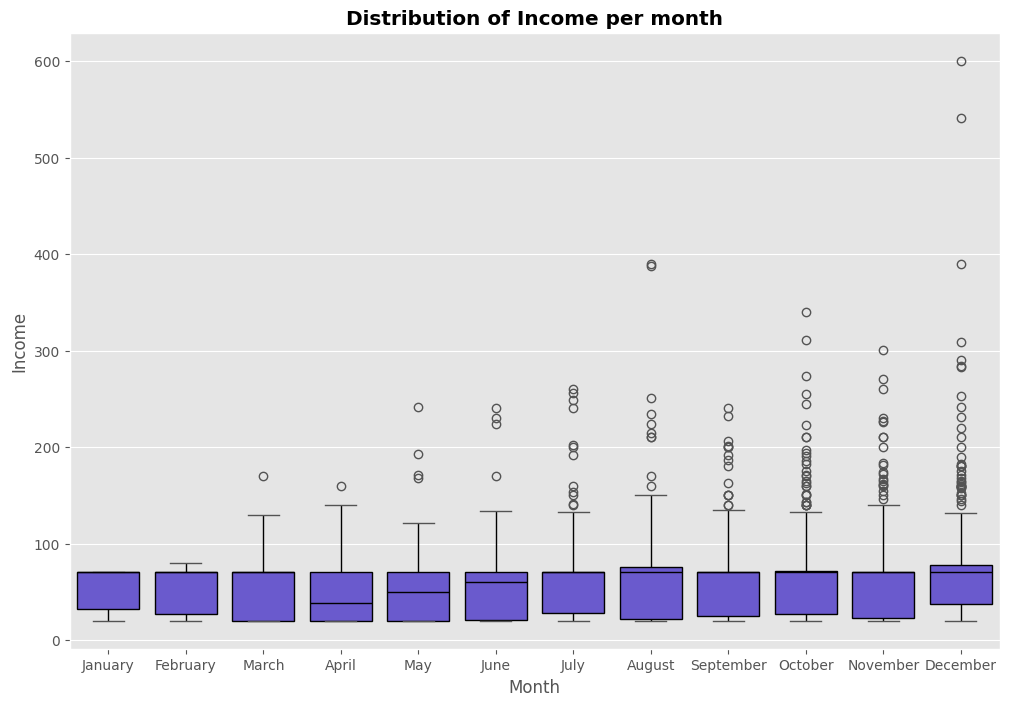

In [115]:
order = list(calendar.month_name)[1:]
plt.figure (figsize= (12,8))
sns.boxplot (
    data = combined_frames, 
    x = "month", 
    y = "total_cost_per_month",
    order = order, 
    boxprops = dict (facecolor = "slateblue", edgecolor = "black"),
    whiskerprops = dict (color = "black"),
    medianprops = dict (color = "black")
)

plt.title ("Distribution of Income per month", fontdict = {"weight": "bold"})
plt.xlabel ("Month")
plt.ylabel ("Income")
plt.show ()


Monthly revenue distribution stays close to each plan's base price but widens toward year end due to overages and seasonal usage spikes.


Revenue analysis shows clear plan differences: Ultimate users contribute higher and steadier per-user revenue; Surf generates more total revenue because of more customers and overage charges.


## 13. Test statistical hypotheses


Test the hypothesis that average revenue differs between Ultimate and Surf users. State H0/H1, choose the test, and set alpha.


To pick the right test, check normality for revenues in each plan (Shapiro–Wilk).


In [116]:
# Normality function
def normality (data): 
    mu, sigma = st.norm.fit (data)

    x_hat = np.linspace (min(data), max(data), num = 100)
    y_hat = st.norm.pdf (x_hat, mu, sigma)

    fig, ax = plt.subplots (figsize = (7,4))
    plt.plot (x_hat, y_hat, linewidth = 2, label = "normal")
    plt.hist (x = data, density=True, bins = 30, alpha = 0.5)
    plt.plot (data, np.full_like (data, -0.0001), "|k", markeredgewidth = 1)


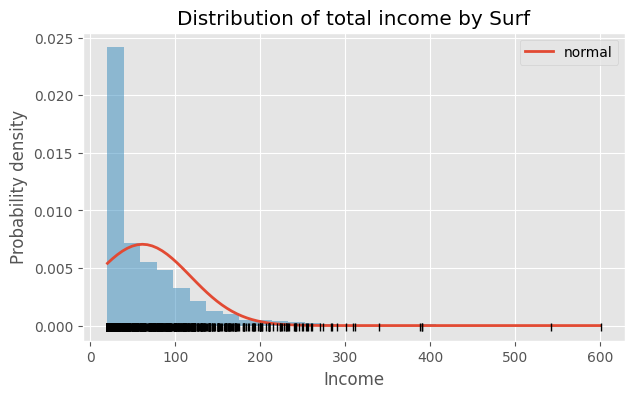

In [117]:
surf_data = combined_frames[combined_frames["plan"] == "surf"]
surf_income = surf_data ["total_cost_per_month"]

normality (surf_income)

plt.title ("Distribution of total income by Surf")
plt.xlabel ("Income") 
plt.ylabel ("Probability density")
plt.legend ();


In [118]:
stat, p_value = st.shapiro (surf_income)
print (f"Statistic = {round (stat, 4)}, p_value = {round (p_value, 4)}")


Statistic = 0.7323, p_value = 0.0


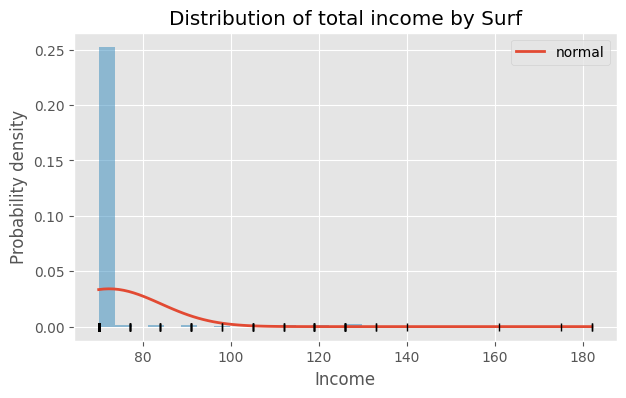

In [119]:
ultimate_data = combined_frames[combined_frames["plan"] == "ultimate"]
ultimate_income = ultimate_data ["total_cost_per_month"]

normality (ultimate_income)

plt.title ("Distribution of total income by Surf")
plt.xlabel ("Income") 
plt.ylabel ("Probability density")
plt.legend ();


In [120]:
stat, p_value = st.shapiro (ultimate_income)
print (f"Statistic = {round (stat, 4)}, p_value = {round (p_value, 4)}")


Statistic = 0.2083, p_value = 0.0


Normality checks for Surf and Ultimate revenues reject normality assumptions, so parametric t-tests are unsuitable.


Given non-normality and the directional expectation, use a one-tailed Mann–Whitney U test to compare plan revenues.


In [121]:
alpha = 0.01
stat, p_value = st.mannwhitneyu (ultimate_income, surf_income, alternative="greater")

if p_value < alpha: 
    print (f"Reject the null hypothesis with p_value = {round (p_value, 4)}")
else: 
    print (f"Fail to reject the null hypothesis with p_value = {round (p_value, 4)}")


Reject the null hypothesis with p_value = 0.0


With p-value = 0.0 < α = 0.01, reject H0 and conclude Ultimate per-user revenue is significantly higher than Surf.


Test whether average revenue in the NY–NJ region differs from other regions.


State H0/H1, choose the test, and set alpha for the regional comparison.


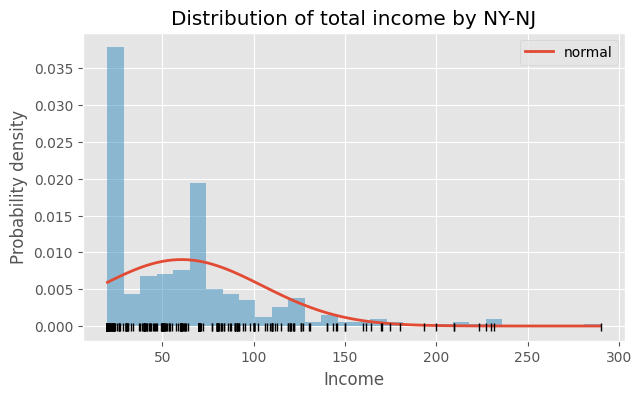

In [122]:
# Normality test

city_ny = combined_frames[combined_frames["city"].str.contains ("NY-NJ")]
ny_income = city_ny["total_cost_per_month"]

normality (ny_income)

plt.title ("Distribution of total income by NY-NJ")
plt.xlabel ("Income") 
plt.ylabel ("Probability density")
plt.legend ();


In [123]:
stat, p_value = st.shapiro (ny_income)
print (f"Statistic = {round (stat, 4)}, p_value = {round (p_value, 4)}")


Statistic = 0.8272, p_value = 0.0


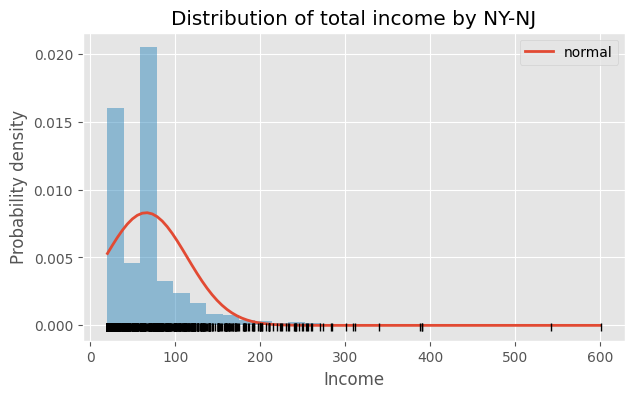

In [124]:
other_cities = combined_frames[~combined_frames["city"].str.contains ("NY-NJ")]
other_income = other_cities["total_cost_per_month"]

normality(other_income)

plt.title ("Distribution of total income by NY-NJ")
plt.xlabel ("Income") 
plt.ylabel ("Probability density")
plt.legend ();


In [125]:
stat, p_value = st.shapiro (other_income)
print (f"Statistic = {round (stat, 4)}, p_value = {round (p_value, 4)}")


Statistic = 0.739, p_value = 0.0


Normality checks for NY–NJ and other-city revenues also reject normality assumptions.


Use a two-tailed Mann–Whitney U test (no directional prior) to compare regional revenues.


In [126]:
alpha = 0.01
stat, p_value = st.mannwhitneyu (ny_income, other_income, alternative="two-sided")

if p_value < alpha: 
    print (f"Reject the null hypothesis with p_value = {round (p_value, 4)}")
else: 
    print (f"Fail to reject the null hypothesis with p_value = {round (p_value, 4)}")


Reject the null hypothesis with p_value = 0.0052


The two-tailed Mann–Whitney U test shows a significant revenue difference between NY–NJ and other regions.


## 14. Overall conclusion
List the key conclusions covering major assumptions and processing/analysis choices.


**Global Project Conclusion**

A comprehensive review of Megaline usage and revenue highlights key differences between Surf and Ultimate at both individual and aggregate levels.

1. **Service consumption (minutes, messages, data):** Ultimate users consume more per person; Surf carries higher total volume because it has more subscribers.
2. **Revenue per plan:** Surf currently drives higher total revenue thanks to its larger base and overage charges. Ultimate delivers higher and steadier per-user revenue; a Mann–Whitney U test confirms Ultimate per-user revenue is significantly greater than Surf.
3. **Variability and patterns:** Surf shows more heterogeneous behavior with some users incurring high overages. Ultimate is more homogeneous and predictable.
4. **Seasonality and trends:** Usage and revenue rise toward year end, likely due to holidays and higher digital activity.

**Strategic recommendation:** Keep Surf as the volume engine, but prioritize acquiring more Ultimate subscribers; each Ultimate customer yields higher, more stable revenue and could close or surpass Surf's total revenue if the subscriber base grows.


---
## Predictive model (plan classification)


# 1. Packages

In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2. Dataset validation

In [128]:
df = pd.read_csv (r'C:\Users\juand\OneDrive\Escritorio\TripleTen\Project 9\Megaline-EDA-Predictive-Modeling\Datasets\users_behavior.csv')
#df = pd.read_csv (r'C:\Users\valen\OneDrive\Escritorio\Juano_VS\Megaline-EDA-Predictive-Modeling\Dataset\users_behavior.csv')
print (df.info())
print ()
print (df.head())
print ()
print ('Number of duplicated records:', sum(df.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None

   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0

Number of duplicated records: 0


# 3. Data segmentation

In [129]:
X = df.drop ('is_ultra', axis=1)
y = df['is_ultra']
x_train, x_test, y_train, y_test = train_test_split (X, y, test_size = 0.75, random_state=12345)

# 4. Model selection

In [130]:
# Decision Tree
best_score = 0
best_depth = 0
for i in range (1, 21): 
    tree = DecisionTreeClassifier (random_state=12345, max_depth=i)
    tree.fit (x_train, y_train)
    score = tree.score (x_test, y_test)
    if score > best_score: 
        best_score = score
        best_depth = i
print ('Best model in the validation set has a depth of:', best_depth, 'with a score of:', best_score)

Best model in the validation set has a depth of: 8 with a score of: 0.7942762339278308


In [131]:
# Random Forest
best_score = 0
best_estimator = 0
for est in range (1, 101): 
    forest = RandomForestClassifier (random_state=12345, n_estimators=est)
    forest.fit (x_train, y_train)
    score = forest.score (x_test, y_test)
    if score > best_score: 
        best_score = score
        best_estimator = est
print ('The accuracy for the best model in the validation set (n_estimators={}): {}'.format (best_estimator, best_score))

The accuracy for the best model in the validation set (n_estimators=54): 0.7946909995852344


In [132]:
# Logistic Regression 
logi = LogisticRegression (random_state = 12345, solver='liblinear')
logi.fit (x_train, y_train)
score_train = logi.score (x_train, y_train)
score_test = logi.score (x_test, y_test)

print ('The accuracy for the logistic regression model in the training set was: ', score_train)
print ('The accuracy for the logistic regression model in the testing set was: ', score_test)

The accuracy for the logistic regression model in the training set was:  0.7409713574097135
The accuracy for the logistic regression model in the testing set was:  0.7465781833264206


## 4.1. Findings from the Model Quality Investigation

During the model evaluation phase, several classification algorithms were tested, including Decision Tree, Logistic Regression, and Random Forest. For each model, different hyperparameters were tuned to identify the configuration with the highest predictive performance.

Decision Tree: Tested with varying max_depth values from 1 to 20. The model reached a maximum accuracy of ~0.7942, which met the required threshold but did not outperform the other models.

Logistic Regression: Tested using the liblinear solver. However, the model did not meet the 0.75 threshold, achieving an accuracy of ~0.7466 on the test set.

Random Forest: Evaluated with n_estimators ranging from 1 to 101. The model showed consistent improvements as the number of trees increased. The best configuration was achieved with 54 estimators, yielding an accuracy of ~0.7947, surpassing the project threshold by 0.0447 points.

Conclusion

Among all tested models, the RandomForestClassifier demonstrated the best performance and generalization ability for predicting Megaline customer plan categories. Hyperparameter tuning confirmed that increasing the number of estimators significantly improved accuracy up to the optimal value found at n_estimators = 54.

## 4.2. Final Model Evaluation on the Test Set
After selecting the RandomForestClassifier with 54 estimators as the best-performing model during the hyperparameter tuning phase, the final step is to evaluate its performance on the test set, which contains data unseen during both training and model selection. This evaluation provides an unbiased estimate of the model’s ability to generalize to new customers.

In [133]:
best_model = RandomForestClassifier (random_state=12345, n_estimators=54)
best_model.fit (x_train, y_train)
predictions = best_model.predict (x_test)
score = accuracy_score (y_test, predictions)

print(f"The final accuracy score of the best model (Random Forest) on the test set is: {score:.4f}")

The final accuracy score of the best model (Random Forest) on the test set is: 0.7947


Final Result

The selected RandomForestClassifier achieved a final test accuracy of ≈0.7947, confirming that it generalizes well to unseen data and successfully meets the project threshold of 0.75. This result validates the model as a reliable solution for predicting Megaline customer plan categories.

# 5. Sanity check¶
Sanity check was performed to verify that the RandomForestClassifier is actually learning meaningful patterns rather than predicting at random.

First, the class distribution of the target variable was inspected:

## 5.1. Verify classes balance

In [134]:
y_train.value_counts (normalize=True)

is_ultra
0    0.665006
1    0.334994
Name: proportion, dtype: float64

## 5.2. Conclusion

The class distribution revealed that the most frequent class represents approximately 66% of the data.

Therefore:

A random classifier would be expected to achieve around 50% accuracy.

A trivial classifier that always predicts the majority class would achieve approximately 66% accuracy.

For comparison: 

| Model                         | Expected Accuracy |
| ----------------------------- | ----------------- |
| Random guessing               | ~0.50             |
| Majority-class predictor      | ~0.66             |
| **Final Random Forest model** | **~0.7947**       |

These results confirm that the model significantly outperforms both a random baseline and a trivial majority-class classifier.
Therefore, it has learned meaningful patterns from the data and successfully passes the sanity check.